In [1]:
# Import General Utilities
import numpy as np
import os
import sys
import random
from tqdm.notebook import tqdm, trange
import time
import datetime

#Import tensorflow and its requirements
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.datasets as tfds
import tensorflow.experimental.numpy as tnp
from tensorflow.data.experimental import cardinality as dlen
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
AUTOTUNE = tf.data.AUTOTUNE
tnp.experimental_enable_numpy_behavior()

# Import plotting tools and image converters
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import imageio
from IPython import display

# Import file path variable handling
from pathlib import Path
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Constants
batch_size = 20
buffer_size = 64
epochs = 350
img_height = 256
img_width = 256
num_examples_to_generate = 8

print(tf.__version__)

2.7.0-dev20210803


In [2]:
# Download OASIS Dataset from the provided link

def download_and_unzip(url, extract_to='.'): # Credit to Antoine Hebert
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)
    http_response.close()

root_dir = '/root/.keras/datasets'
data_dir = Path(root_dir) / 'keras_png_slices_data'

try:
    assert(len(os.listdir(data_dir)) == 6)
except:
    if not os.path.exists(root_dir):
        os.makedirs(root_dir)
    _URL = "https://cloudstor.aarnet.edu.au/plus/s/tByzSZzvvVh0hZA/download"
    download_and_unzip(_URL, extract_to=root_dir)

print(f"Data Directory is {data_dir}")
print(f"Contents: \n\r {os.listdir(data_dir)}")

# Folder Directory Paths
train_dir = data_dir / 'keras_png_slices_train'
train_ans_dir = data_dir / 'keras_png_slices_seg_train'
test_dir = data_dir / 'keras_png_slices_test'
test_ans_dir = data_dir / 'keras_png_slices_seg_test'
val_dir = data_dir / 'keras_png_slices_validate'
val_ans_dir = data_dir / 'keras_png_slices_seg_validate'

train_ds_list = tf.data.Dataset.list_files(str(train_dir/'*.*'), shuffle=True)
test_ds_list = tf.data.Dataset.list_files(str(test_dir/'*.*'), shuffle=True)
val_ds_list = tf.data.Dataset.list_files(str(val_dir/'*.*'), shuffle=False)

train_ds = train_ds_list.take(dlen(train_ds_list))
test_ds = test_ds_list.take(dlen(test_ds_list))
val_ds = val_ds_list.take(dlen(val_ds_list))

print(f"Train Set is {dlen(train_ds_list)} images, Test Set is {dlen(test_ds_list)} images and Validation Set is {dlen(val_ds_list)} images.")

Data Directory is \root\.keras\datasets\keras_png_slices_data
Contents: 
 ['keras_png_slices_seg_test', 'keras_png_slices_seg_train', 'keras_png_slices_seg_validate', 'keras_png_slices_test', 'keras_png_slices_train', 'keras_png_slices_validate']
Train Set is 9664 images, Test Set is 544 images and Validation Set is 1120 images.


In [3]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=1)
    tfimg = tf.image.resize(img, [img_height, img_width])
    tfimg = (tfimg / 255.0) - 0.5 # Normalise data
    # Resize the image to the desired size
    return tfimg

def process_path(file_path):
    #label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

def configure_for_performance(ds, batches):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batches)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_raw = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_raw = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
#val_ds_raw = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = configure_for_performance(train_ds_raw, batch_size)
test_ds = configure_for_performance(test_ds_raw, batch_size)
#val_ds = configure_for_performance(val_ds_raw, batch_size)

In [4]:
# Adapted from the Keras VQVAE tutorial - https://keras.io/examples/generative/vq_vae/
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, label="vectorizer", beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.label = label
        self.beta = beta  # This parameter is best kept between [0.25, 2] as per the paper.

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name=self.label,
        )

    def call(self, x):
        input_shape = tf.shape(x)

        # Quantization.
        encoding_indices = self.get_code_indices(x)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, x):
        # Calculate L2-normalized distance between the inputs and the codes.

        # flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened_inputs = tf.reshape(x, [-1, self.embedding_dim])

        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


class SkipConn(layers.Layer):
    def __init__(self, in_channels, channels, **kwargs):
        super().__init__(**kwargs)

        self.conv1 = layers.Conv2D(channels, 3, activation="relu", padding="same")
        self.conv2 = layers.Conv2D(in_channels, 1, activation="relu", padding="same")

    def call(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        out = x + input
        return out


# Adapted from Razavi et al - https://paperswithcode.com/method/vq-vae-2
def get_encoder(input_shape, channels=128, strides=4, name='encoder'):
    encoder_inputs = Input(shape=input_shape, name=name+'input')

    if strides == 4:
        x = layers.Conv2D(channels // 2, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(channels, 3, activation="relu", strides=2, padding="same")(x)

    elif strides == 2:
        x = layers.Conv2D(channels // 2, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        
    x = layers.Conv2D(channels, 3, activation="relu", padding="same")(x)

    for i in range(2):
        x = SkipConn(channels, 32)(x)
        
    return Model(inputs=encoder_inputs, outputs=x, name=name)


def get_decoder(input_shape, out_channels=128, channels=128, strides=4, name='decoder'):
    latent_inputs = Input(shape=input_shape, name=name+'decoder_input')

    x = layers.Conv2D(channels, 3, activation="relu", padding="same")(latent_inputs)

    for i in range(2):
        x = SkipConn(channels, 32)(x)

    if strides == 4:
        x = layers.Conv2DTranspose(channels // 2, 3, activation="relu", strides=2, padding="same")(x)

    decoder_outputs = layers.Conv2DTranspose(out_channels, 3, strides=2, padding="same")(x)
    return Model(inputs=latent_inputs, outputs=decoder_outputs, name=name)


class VQVAE(Model):
    def __init__(self, latent_dim=16, num_embeddings=128):
        super(VQVAE, self).__init__()

        self.enc_b = get_encoder(input_shape=(256, 256, 1), channels=round(latent_dim / 2), strides=4, name="encoder_b")
        self.enc_t = get_encoder(input_shape=(64, 64, round(latent_dim / 2)), channels=latent_dim * 2, strides=2, name="encoder_t")
        self.quantize_t = VectorQuantizer(num_embeddings, latent_dim * 2, label="t_vq")

        self.dec_t = get_decoder(input_shape=(32, 32, latent_dim * 2), out_channels=round(latent_dim / 2), channels=latent_dim * 2, strides=2, name="decoder_t")
        self.quantize_b = VectorQuantizer(num_embeddings, latent_dim, label="b_vq")
        self.upsample_t = layers.Conv2DTranspose(latent_dim, 3, activation="relu", strides=2, padding="same")

        self.dec = get_decoder(input_shape=(64, 64, 2 * latent_dim), out_channels=1, channels=2 * latent_dim, strides=4, name="decoder_b")

    def encode(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_t(enc_t)

        dec_t = self.dec_t(quant_t)
        enc_b = tf.concat([dec_t, enc_b], 3)

        quant_b = self.quantize_b(enc_b)
        #upsample_t = self.upsample_t(quant_t)
        #quant = tf.concat([upsample_t, quant_b], 3)
        
        return quant_t, quant_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = tf.concat([upsample_t, quant_b], 3)
        dec = self.dec(quant)

        return dec

    def encode_to_t(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)
        return enc_t

    def encode_to_b(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_t(enc_t)

        dec_t = self.dec_t(quant_t)
        enc_b = tf.concat([dec_t, enc_b], 3)
        return enc_b

    def call(self, input):
        quant_t, quant_b = self.encode(input)
        dec = self.decode(quant_t, quant_b)

        return dec



In [5]:
trained_vqvae_model = VQVAE(latent_dim=128, num_embeddings=256)
trained_vqvae_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

trained_vqvae_model.load_weights(f'/root/trained_model/model022')

trained_vqvae_model.build((None, 256, 256, 1))
trained_vqvae_model.summary()

Model: "vqvae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_b (Functional)       (None, 64, 64, 64)        96896     
_________________________________________________________________
encoder_t (Functional)       (None, 32, 32, 256)       533440    
_________________________________________________________________
vector_quantizer (VectorQua  multiple                  65536     
ntizer)                                                          
_________________________________________________________________
decoder_t (Functional)       (None, 64, 64, 64)        902016    
_________________________________________________________________
vector_quantizer_1 (VectorQ  multiple                  32768     
uantizer)                                                        
_________________________________________________________________
conv2d_transpose_1 (Conv2DT  multiple                  295040

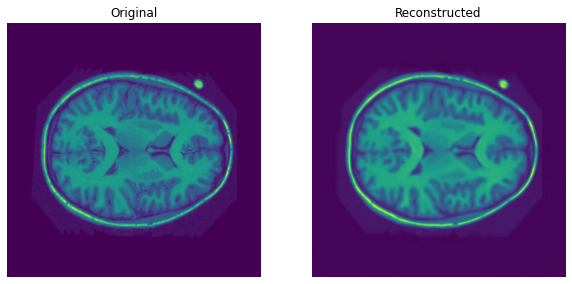

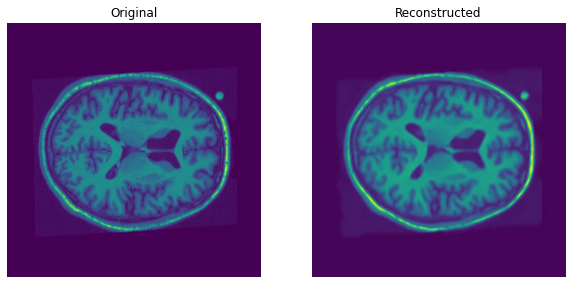

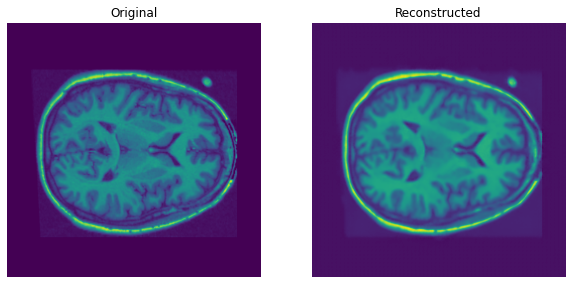

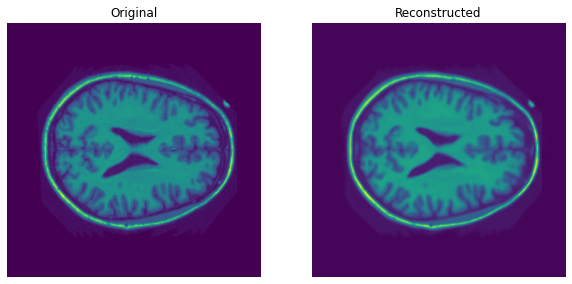

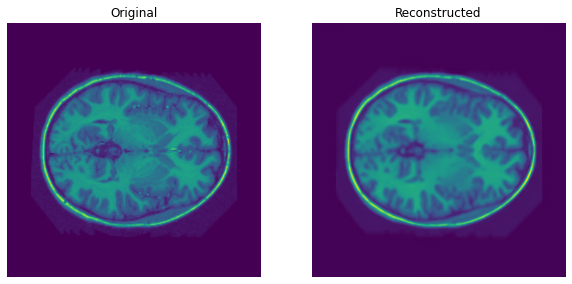

In [6]:
def show_subplot(original, reconstructed):

    original = original + 0.5
    reconstructed = reconstructed + 0.5

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original[:, :, 0])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed[:, :, 0])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


test_images = next(iter(test_ds))
reconstructions_test = trained_vqvae_model.predict(test_images)

for i in range(5):
    show_subplot(test_images[i], reconstructions_test[i])

Low filter encoder is (20, 32, 32, 256), High filter encoder is (20, 64, 64, 128)


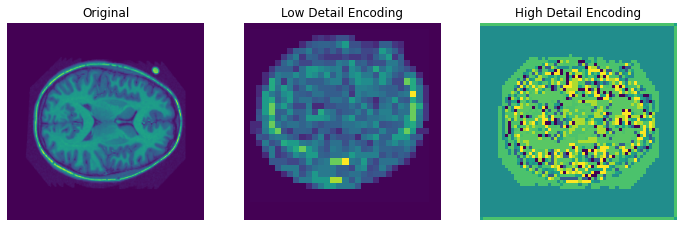

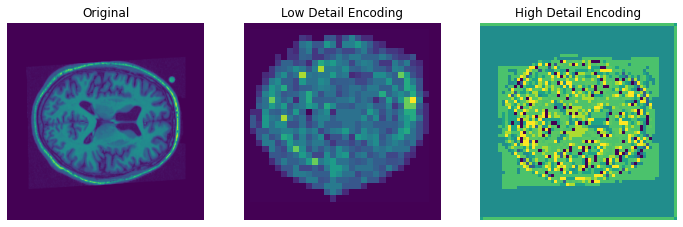

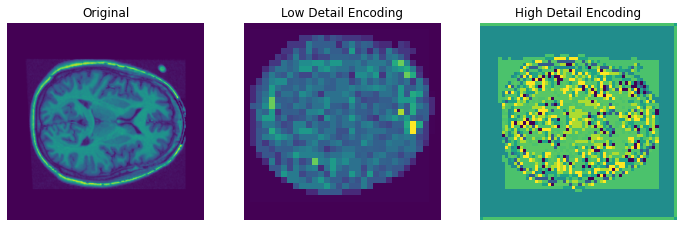

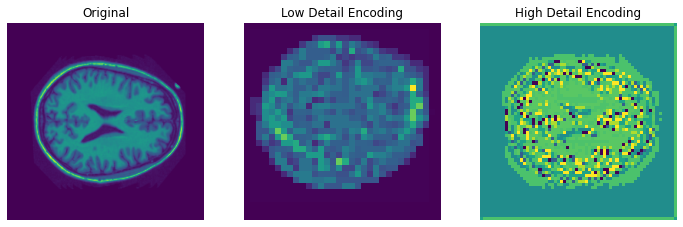

In [7]:
# Testing encoding visualisation
enc_out_t, enc_out_b = trained_vqvae_model.encode(test_images)
print(f"Low filter encoder is {enc_out_t.shape}, High filter encoder is {enc_out_b.shape}")

for i in range(4):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i][:, :, 0] + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(enc_out_t[i][:, :, 0] + 0.5)
    plt.title("Low Detail Encoding")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(enc_out_b[i][:, :, 0] + 0.5)
    plt.title("High Detail Encoding")
    plt.axis("off")
    plt.show()


In [8]:
ssim_total = 0
count = 0

for batch in tqdm(test_ds):
    reconstructed_comp = trained_vqvae_model.predict(batch)

    for i in range(batch.shape[0]):
        original = tf.math.round((batch[i] + 0.5) * 255.0)
        reconstruction = tf.math.round((reconstructed_comp[i] + 0.5) * 255.0)
        ssim = tf.image.ssim(original, reconstruction, max_val=255.0)
        ssim_total += ssim
        count += 1

print(f"Average SSIM score is {ssim_total / count}.")

  0%|          | 0/28 [00:00<?, ?it/s]

Average SSIM score is 0.9380497336387634.


In [9]:
# Generate an encoded dataset for the PixelCNN

def codebooks_t(ds):
    encoded_outputs = trained_vqvae_model.encode_to_t(ds)
    codebook_indices = trained_vqvae_model.quantize_t.get_code_indices(encoded_outputs)
    codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1]).astype(np.float32)

    return codebook_indices

def codebooks_b(ds):
    encoded_outputs = trained_vqvae_model.encode_to_b(ds)
    codebook_indices = trained_vqvae_model.quantize_b.get_code_indices(encoded_outputs)
    codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1]).astype(np.float32)

    return codebook_indices

pixel_ds = configure_for_performance(train_ds_raw, 10)

codebook_tensor_t = 0
codebook_tensor_b = 0
first = True

for batch in tqdm(pixel_ds, desc=f"Extracting Codebook Indices:"):
    if first:
        codebook_tensor_t = codebooks_t(batch)
        codebook_tensor_b = codebooks_b(batch)
        first = False
    else:
        codebook_tensor_t = tf.concat([codebook_tensor_t, codebooks_t(batch)], 0)
        codebook_tensor_b = tf.concat([codebook_tensor_b, codebooks_b(batch)], 0)
        

Extracting Codebook Indices::   0%|          | 0/967 [00:00<?, ?it/s]

In [10]:
# PixelCNN implementation
# Adapted from the Keras VQVAE tutorial - https://keras.io/examples/generative/vq_vae/
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0
        self.mask = tf.cast(self.mask, tf.float32)

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return tf.cast(self.conv(inputs), tf.float32)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])


def pixel_cnn(shape, filters=128, kernels=64, embeddings=128, name="pixel_cnn"):
    pixelcnn_inputs = Input(shape=shape, dtype=tf.int32)
    ohe = tf.one_hot(pixelcnn_inputs, embeddings)
    ohe = tf.cast(ohe, tf.float32)
    x = PixelConvLayer(
        mask_type="A", filters=filters, kernel_size=kernels, activation="relu", padding="same"
    )(ohe)

    for _ in range(2):
        x = ResidualBlock(filters=filters)(x)

    for _ in range(2):
        x = PixelConvLayer(
            mask_type="B",
            filters=filters,
            kernel_size=1,
            strides=1,
            activation="relu",
            padding="valid",
        )(x)

    out = layers.Conv2D(
        filters=embeddings, kernel_size=1, strides=1, padding="valid", activation="sigmoid"
    )(x)

    return Model(pixelcnn_inputs, out, name=name)

In [22]:
# Compile and generate the PixelCNN models for each layer of the VQVAE
pixel_cnn_t = pixel_cnn((32, 32), filters=128, kernels=11, embeddings=512, name="pixel_cnn_top")
pixel_cnn_b = pixel_cnn((64, 64), filters=128, kernels=11, embeddings=256, name="pixel_cnn_bottom")

pixel_cnn_t.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
)

pixel_cnn_b.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
)

pixel_cnn_t.load_weights(f"/root/trained_pixel_model/model022_pixelcnn_t")
pixel_cnn_b.load_weights(f"/root/trained_pixel_model/model022_pixelcnn_b")

In [23]:
# Create a mini sampler model
def gen_priors_layer(model, num_samples=10):
    inputs = Input(shape=model.input_shape[1:])
    x = model(inputs, training=False)
    dist = tfp.distributions.Categorical(logits=x)
    sampled = dist.sample()
    sampler = Model(inputs, sampled)

    # Create an empty array of priors.
    priors = np.zeros(shape=(num_samples,) + (model.input_shape)[1:])
    num_samples, rows, cols = priors.shape

    # Iterate over the priors because generation has to be done sequentially pixel by pixel.
    for row in trange(rows, desc="Predicting priors"):
        for col in range(cols):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = sampler.predict(priors)
            # Use the probabilities to pick pixel values and append the values to the priors.
            priors[:, row, col] = probs[:, row, col]
    return priors

priors_t = gen_priors_layer(pixel_cnn_t)
priors_b = gen_priors_layer(pixel_cnn_b)

Predicting priors:   0%|          | 0/32 [00:00<?, ?it/s]

Predicting priors:   0%|          | 0/64 [00:00<?, ?it/s]

(10, 32, 32)


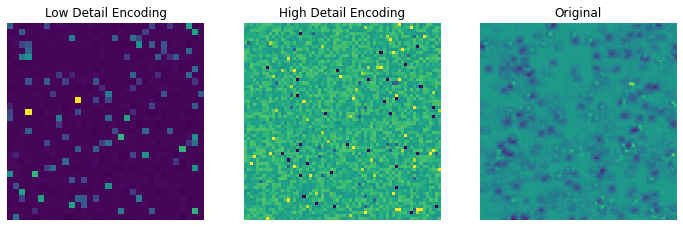

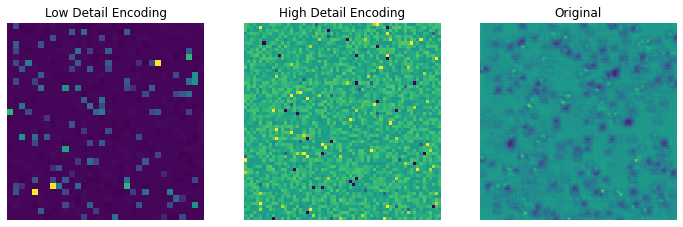

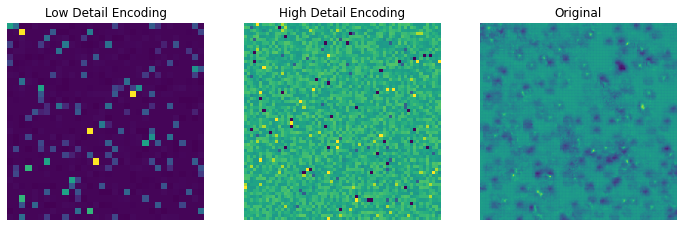

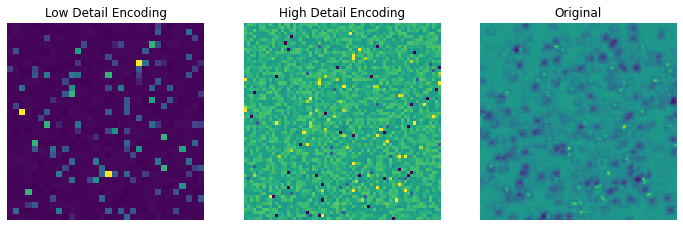

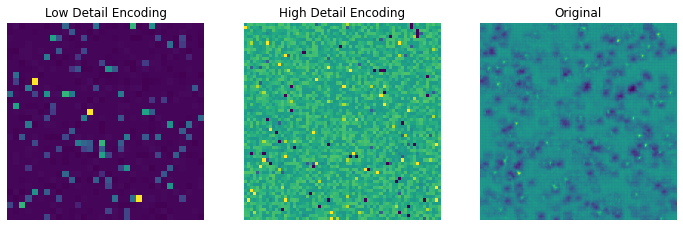

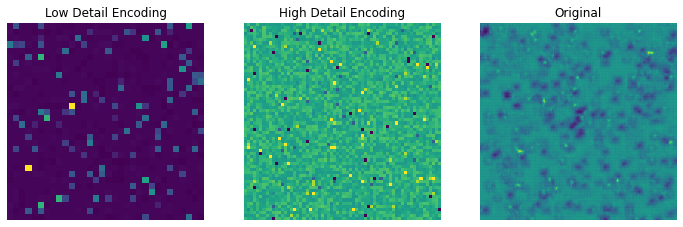

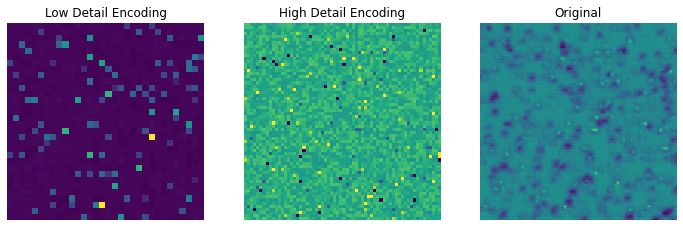

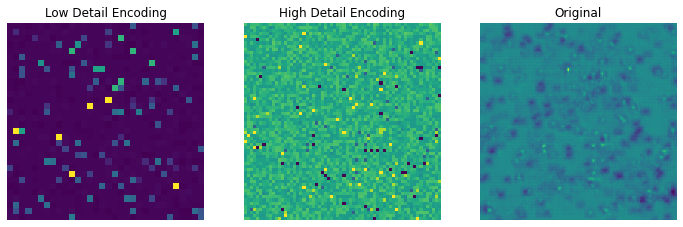

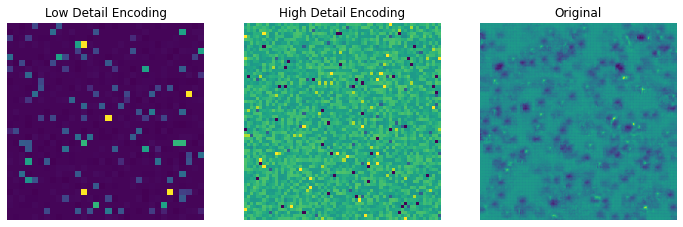

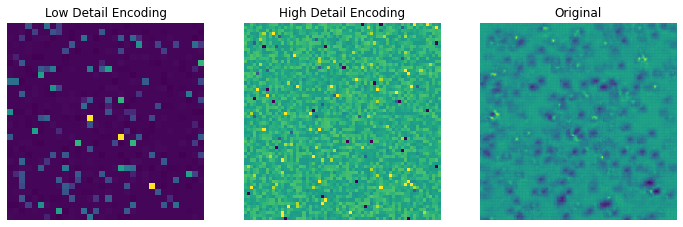

In [24]:
def show_generated_image(samples_t, samples_b):

    generated = trained_vqvae_model.decode(samples_t, samples_b)

    for i in range(samples_t.shape[0]):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(samples_t[i][:, :, 0] + 0.5)
        plt.title("Low Detail Encoding")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(samples_b[i][:, :, 0] + 0.5)
        plt.title("High Detail Encoding")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(generated[i][:, :, 0] + 0.5)
        plt.title("Original")
        plt.axis("off")

        plt.show()

def gen_encodings(priors, quantizer):
    # Perform an embedding lookup.

    encodings = tf.one_hot(priors, quantizer.num_embeddings)
    quantized = tf.matmul(encodings, quantizer.embeddings, transpose_b=True)
    quantized = tf.reshape(quantized, priors.shape + (quantizer.embedding_dim,))

    return quantized

print(priors_t.shape)
pad_t = gen_encodings(priors_t, trained_vqvae_model.quantize_t)
pad_b = gen_encodings(priors_b, trained_vqvae_model.quantize_b)

show_generated_image(pad_t, pad_b)

In [ ]:
pixel_cnn_t = pixel_cnn((32, 32), filters=128, kernels=64, embeddings=128, name="pixel_cnn_top")
pixel_cnn_t.load_weights(f"/root/trained_pixel_model/model019_t")
pixel_cnn_b = pixel_cnn((64, 64), filters=128, kernels=64, embeddings=256, name="pixel_cnn_bottom")
pixel_cnn_b.load_weights(f"/root/trained_pixel_model/model019_b")